# Demonstrating Access to NCEO ARD through Python: A Guide

This guide presents a straightforward demonstration on how to access the Analysis Ready Data (ARD) product from the National Centre for Earth Observation (NCEO), utilizing the SpatioTemporal Asset Catalog (STAC) FastAPI server. 

The process will initially involve the filtering of data using a set of coordinates, spanning a period from January to May, 2023. Then, we use the `stackstac` Python library to read the STAC items and transform them into the `xarray` data structure. Finally, we compute a monthly median composite, excluding cloudy pixels via the application of the cloud mask band.

This demo closely follows the `stackstac` [basic example notebook](https://stackstac.readthedocs.io/en/latest/basic.html)

## Filtering the NCEO ARD STAC catalog

In [1]:
import stackstac
import pystac_client
# NCEO ARD STAC API
URL = "http://192.171.169.103:8080"
catalog = pystac_client.Client.open(URL)

In [2]:
%%time
# south east england
lon, lat = 1.033957, 52.693997
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["UK-sentinel-2"],
    datetime="2023-01-01/2023-06-30"
).get_all_items()
len(items)

CPU times: user 172 ms, sys: 25.9 ms, total: 198 ms
Wall time: 483 ms


128

## Load the data into xarray data cube

In [3]:
%%time 

# define the output spatial reference and resolution
item = items[0]
epsg = int(item.properties['sentinel:epsg'])

stack = stackstac.stack(items, epsg= epsg, resolution=10)
stack

CPU times: user 90.3 ms, sys: 6.63 ms, total: 96.9 ms
Wall time: 94.7 ms


/Users/fengyin/mambaforge/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-bab45374215894b97c0d70b5ac82de83' (time: 128,
                                                                band: 49,
                                                                y: 12195,
                                                                x: 12188)>
dask.array<fetch_raster_window, shape=(128, 49, 12195, 12188), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/29)
  * time                              (time) datetime64[ns] 2023-01-01T11:14:...
    id                                (time) <U25 'S2A_31UCU_20230101T111451'...
  * band                              (band) <U12 'AOT' 'B01' ... 'toa_overview'
  * x                                 (x) float64 2.899e+05 ... 4.118e+05
  * y                                 (y) float64 5.903e+06 ... 5.781e+06
    Scale-factors:cloud               float64 0.01
    ...                                ...
    gsd                               (band) int64 500 60 10 10 ... 20 20 10 10
    title                             (band) <U44 'Aerosol Optical Thickness'...
    common_name                       (band) object None 'coastal' ... None None
    center_wavelength                 (band) object None 0.4439 ... None None
    full_width_half_max               (band) object None 0.027 ... None None
    epsg                              int64 32631
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(289940, 5781430, 411820, 5903...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 289940.00|\n| 0.00,-10.00, 5903380.00|\n| 0.0...
    resolution:  10

## Compute monthly composite 

In [4]:
def mask_cloud_shadow(data):
    # create mask from the cloud prob band
    bad = data.loc[:, 'cloud'] > 40
    data = data.where(~bad)
    return data
stack = mask_cloud_shadow(stack)

In [5]:

lowcloud = stack[stack["eo:cloud_cover"] < 50]
rgb = lowcloud.sel(band=["B04", "B03", "B02"])

monthly = rgb.resample(time="MS").median("time", keep_attrs=True)
monthly

<xarray.DataArray 'stackstac-bab45374215894b97c0d70b5ac82de83' (time: 6,
                                                                band: 3,
                                                                y: 12195,
                                                                x: 12188)>
dask.array<stack, shape=(6, 3, 12195, 12188), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                              (band) <U12 'B04' 'B03' 'B02'
  * x                                 (x) float64 2.899e+05 ... 4.118e+05
  * y                                 (y) float64 5.903e+06 ... 5.781e+06
    Scale-factors:cloud               float64 0.01
    collection                        <U8 'NCEO_ARD'
    constellation                     <U10 'sentinel-2'
    ...                                ...
    Atmospheric-Correction:version    <U11 'SIAC-V2.3.5'
    Scale-factors:uncertainty         float64 0.0001
    view:off_nadir                    int64 0
    Scale-factors:reflectance         float64 0.0001
    epsg                              int64 32631
  * time                              (time) datetime64[ns] 2023-01-01 ... 20...
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(289940, 5781430, 411820, 5903...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 289940.00|\n| 0.00,-10.00, 5903380.00|\n| 0.0...
    resolution:  10

## Compute over area of interest

In [6]:
import pyproj
x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 2000  # meters

In [7]:
aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-bab45374215894b97c0d70b5ac82de83' (time: 6,
                                                                band: 3,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(6, 3, 400, 400), dtype=float64, chunksize=(1, 1, 390, 400), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                              (band) <U12 'B04' 'B03' 'B02'
  * x                                 (x) float64 3.651e+05 ... 3.691e+05
  * y                                 (y) float64 5.842e+06 ... 5.838e+06
    Scale-factors:cloud               float64 0.01
    collection                        <U8 'NCEO_ARD'
    constellation                     <U10 'sentinel-2'
    ...                                ...
    Atmospheric-Correction:version    <U11 'SIAC-V2.3.5'
    Scale-factors:uncertainty         float64 0.0001
    view:off_nadir                    int64 0
    Scale-factors:reflectance         float64 0.0001
    epsg                              int64 32631
  * time                              (time) datetime64[ns] 2023-01-01 ... 20...
Attributes:
    spec:        RasterSpec(epsg=32631, bounds=(289940, 5781430, 411820, 5903...
    crs:         epsg:32631
    transform:   | 10.00, 0.00, 289940.00|\n| 0.00,-10.00, 5903380.00|\n| 0.0...
    resolution:  10

In [8]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = aoi.compute()

[######                                  ] | 16% Completed | 14.94 ss

/Users/fengyin/mambaforge/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


[########################################] | 100% Completed | 90.18 s


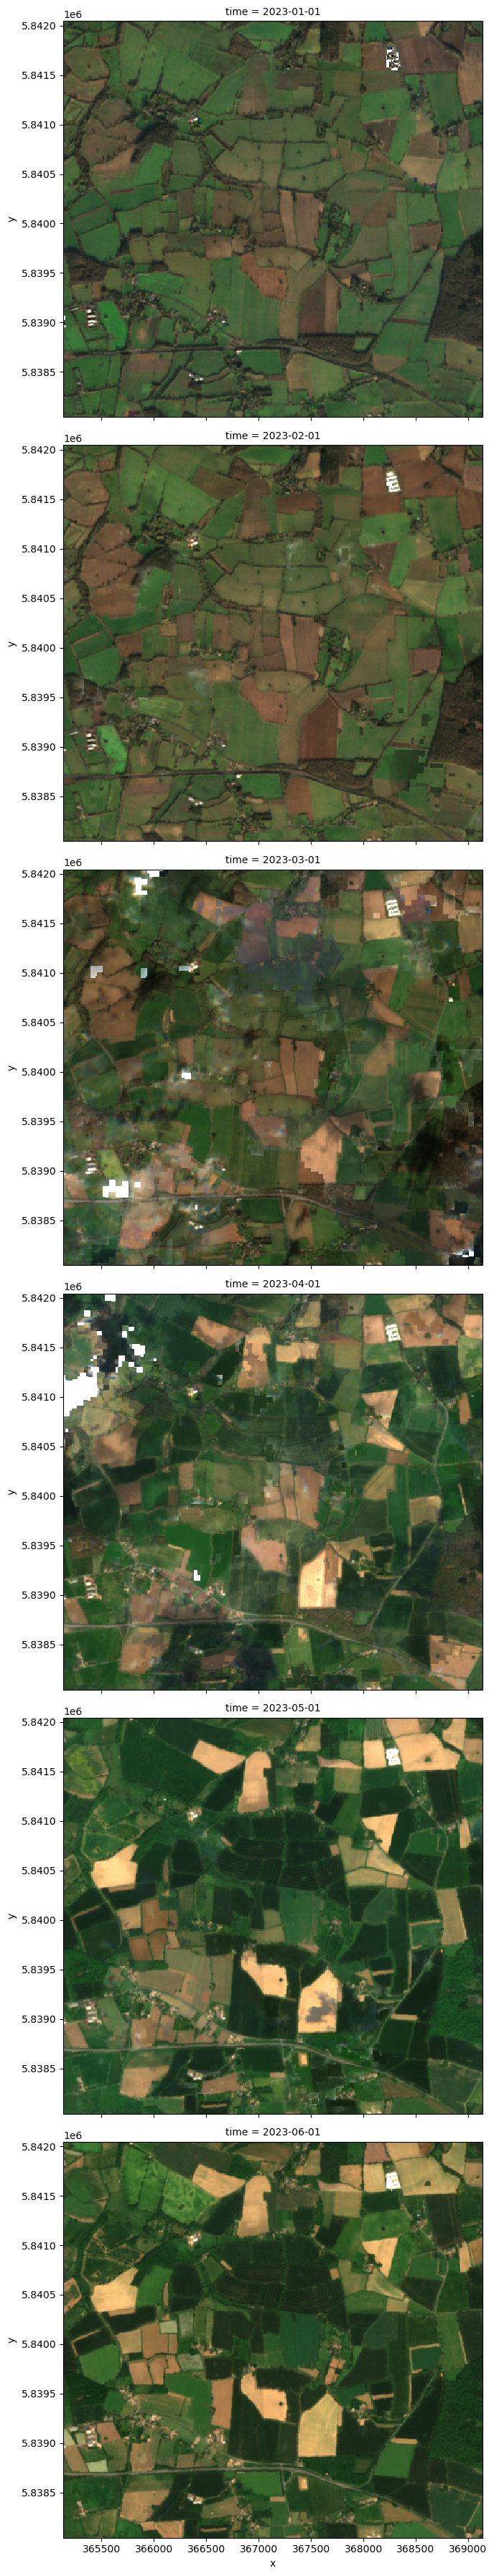

In [9]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6, vmin=0, vmax=2000)